<a href="https://colab.research.google.com/github/phuongthao0515/Computer-Vision-Cellpose-SAM/blob/main/Flow_field_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cellpose-SAM Demo

**Goal:** demonstrate the flow-field segmentation algorithm used in Cellpose and the idea of using a pretrained encoder (SAM) as a feature extractor — without requiring heavy training.

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install cellpose
!pip install timm

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gyzciahc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gyzciahc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=00c5681e0a0e2a7b35263d8e63031e61ff102a6912bfe6251033788cfde4f600
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ggq5vgf/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from scipy import ndimage as ndi
from skimage.draw import disk, ellipse
from skimage.measure import regionprops
from sklearn.cluster import DBSCAN
import ipywidgets as widgets
from IPython.display import display, clear_output

# Conditional imports for SAM and Cellpose
HAS_SAM = False
HAS_CELLPOSE = False
try:
    import torch
    from segment_anything import sam_model_registry
    from torchvision.transforms import Resize, Normalize, ToTensor, Compose
    HAS_SAM = True
except ImportError as e:
    print('SAM-related libraries not available:', e)

try:
    import cellpose
    HAS_CELLPOSE = True
except ImportError as e:
    print('Cellpose not available in this environment:', e)

print('HAS_SAM =', HAS_SAM, 'HAS_CELLPOSE =', HAS_CELLPOSE)


HAS_SAM = True HAS_CELLPOSE = True


In [3]:
# SAM Model Configuration
SAM_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
EXPECTED_MB = 375  # Expected approximate size of the SAM checkpoint in MB
MODEL_TYPE = "vit_b"

# Determine device for SAM if available
if HAS_SAM and torch.cuda.is_available():
    DEVICE = "cuda"
elif HAS_SAM:
    DEVICE = "cpu"
else:
    DEVICE = "not_applicable" # SAM not available

print(f"SAM checkpoint URL: {SAM_URL}")
print(f"SAM checkpoint name: {SAM_CHECKPOINT}")
print(f"SAM model type: {MODEL_TYPE}")
print(f"SAM device: {DEVICE}")

SAM checkpoint URL: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
SAM checkpoint name: sam_vit_b_01ec64.pth
SAM model type: vit_b
SAM device: cpu


In [24]:
def make_synthetic_cells(image_size=(256,256), n_cells=8, overlap_factor=0.5, shape_mix_prob=0.3, noise_level=0.05, seed=0):
    """
    Generates a synthetic image with overlapping circular/elliptical cells and a corresponding ground truth mask.

    Args:
        image_size (tuple): Desired (height, width) of the output image.
        n_cells (int): Number of synthetic cells to generate.
        overlap_factor (float): Controls the density of cell placement (0.0 for minimal overlap, 1.0 for high overlap).
        shape_mix_prob (float): Probability of drawing an ellipse instead of a disk (0.0 for only disks, 1.0 for mostly ellipses).
        noise_level (float): Standard deviation of Gaussian noise added to the image.
        seed (int): Seed for the random number generator to ensure reproducibility.

    Returns:
        tuple: (img (np.array), label_mask (np.array))
               - img: The generated synthetic image.
               - label_mask: Ground truth mask with unique integer labels for each cell.
    """
    H, W = image_size
    rng = np.random.default_rng(seed)

    img = np.zeros((H,W), dtype=float)
    label_mask = np.zeros((H,W), dtype=np.int32)

    min_dim = min(H, W)

    for i in range(1, n_cells + 1):
        # Determine max radius based on image size and overlap factor
        max_r = int(min_dim * (0.10 + 0.15 * (1 - overlap_factor)))
        min_r = int(max_r * 0.5)

        # Center generation - influenced by overlap_factor to encourage closer placement
        # Centers will be generated within a smaller boundary if overlap_factor is high
        center_margin = int(min_r * (1.5 - overlap_factor))
        cy = rng.integers(low=center_margin, high=H - center_margin)
        cx = rng.integers(low=center_margin, high=W - center_margin)

        is_ellipse = rng.random() < shape_mix_prob

        if is_ellipse:
            # Generate radii and rotation for ellipse
            r_radius = rng.integers(low=min_r, high=max_r)
            c_radius = rng.integers(low=min_r, high=max_r)
            rotation = rng.uniform(0, np.pi) # Random rotation in radians
            rr, cc = ellipse(cy, cx, r_radius, c_radius, rotation=rotation, shape=(H,W))
        else:
            # Generate radius for disk
            r = rng.integers(low=min_r, high=max_r)
            rr, cc = disk((cy, cx), r, shape=(H,W))

        # Add intensity to image, handling overlaps by combining intensities
        # The `label_mask` will naturally be overwritten, assigning the label of the last drawn cell
        intensity_val = 0.5 + 0.5 * rng.random()
        img[rr,cc] = np.maximum(img[rr,cc], intensity_val) # Combine intensities, max for brighter cells
        label_mask[rr,cc] = i # Overwrite with current cell's label

    img = ndi.gaussian_filter(img, sigma=1.0)
    img = img + noise_level * rng.standard_normal(size=(H,W))
    img = np.clip(img, 0, 1)
    return img, label_mask


def labels_to_flows(label_mask):
    """
    Converts a ground truth label mask into a flow field and a probability map.
    Each pixel within a labeled region points towards the center of that region.

    Args:
        label_mask (np.array): 2D array where each pixel contains an integer label
                                for its instance (0 for background).

    Returns:
        tuple: (flow (np.array), prob (np.array))
               - flow: 3D array (H, W, 2) where flow[..., 0] is dx and flow[..., 1] is dy.
                       Vectors are normalized to unit length.
               - prob: 2D array (H, W) indicating the probability of being foreground.
    """
    H, W = label_mask.shape
    flow = np.zeros((H, W, 2), dtype=np.float32)
    prob = (label_mask > 0).astype(np.float32)
    props = regionprops(label_mask)
    for reg in props:
        coords = reg.coords
        cy = np.mean(coords[:,0])
        cx = np.mean(coords[:,1])
        dy = cy - coords[:,0]
        dx = cx - coords[:,1]
        norms = np.sqrt(dx*dx + dy*dy)
        nz = norms > 0
        dx[nz] /= (norms[nz] + 1e-8)
        dy[nz] /= (norms[nz] + 1e-8)
        flow[coords[:,0], coords[:,1], 0] = dx
        flow[coords[:,0], coords[:,1], 1] = dy
    return flow, prob


def follow_flows(flow, n_iters=200, step_size=1.0, record_steps=None):
    """
    Simulates particle movement by following the flow field.

    Args:
        flow (np.array): 3D array (H, W, 2) representing the flow field (dx, dy).
        n_iters (int): Number of integration steps for flow dynamics.
        step_size (float): Multiplier for each flow vector per iteration.
        record_steps (list, optional): A list of iteration numbers at which to record
                                       the intermediate coordinates. If None, only
                                       the final coordinates are returned.

    Returns:
        np.array or tuple:
               - If record_steps is None: 3D array (H, W, 2) of final coordinates.
               - If record_steps is provided: (final_coords, intermediate_coords_list)
                 where intermediate_coords_list is a list of 2D arrays (N_pixels, 2)
                 for each recorded step, plus the initial coordinates.
    """
    H, W, _ = flow.shape
    yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    coords = np.stack([yy.astype(np.float32), xx.astype(np.float32)], axis=-1)
    coords_flat = coords.reshape(-1,2)

    intermediate_coords = []
    if record_steps is not None:
        intermediate_coords.append(coords_flat.copy()) # Record initial state

    def sample_flow_at(pts):
        r = pts[:,0]
        c = pts[:,1]
        r0 = np.floor(r).astype(int)
        c0 = np.floor(c).astype(int)
        r1 = np.clip(r0+1, 0, H-1)
        c1 = np.clip(c0+1, 0, W-1)

        wr = r - r0
        wc = c - c0

        # Bilinear interpolation
        f00 = flow[r0, c0]
        f10 = flow[r1, c0]
        f01 = flow[r0, c1]
        f11 = flow[r1, c1]

        f_interp_r0 = f00 * (1-wc)[:,None] + f01 * wc[:,None]
        f_interp_r1 = f10 * (1-wc)[:,None] + f11 * wc[:,None]
        f = f_interp_r0 * (1-wr)[:,None] + f_interp_r1 * wr[:,None]
        return f

    pts = coords_flat.copy()
    for i in range(n_iters):
        f = sample_flow_at(pts)
        # Flow vector contains dx (column change) and dy (row change)
        # So, pts[:,0] for row, pts[:,1] for column
        pts[:,0] = np.clip(pts[:,0] + f[:,1] * step_size, 0, H-1) # Update row coordinate with dy
        pts[:,1] = np.clip(pts[:,1] + f[:,0] * step_size, 0, W-1) # Update column coordinate with dx

        if record_steps is not None and (i + 1) in record_steps:
            intermediate_coords.append(pts.copy())

    final = pts.reshape(H, W, 2)
    if record_steps is not None:
        return final, intermediate_coords
    return final


def cluster_final_positions(final_coords, prob_map, eps=3.0, min_samples=10):
    """
    Clusters the final positions of pixels using DBSCAN to form segmentation masks.

    Args:
        final_coords (np.array): 3D array (H, W, 2) of final pixel coordinates after flow dynamics.
        prob_map (np.array): 2D array (H, W) indicating foreground probability, used to mask pixels.
        eps (float): The maximum distance between two samples for one to be considered
                     as in the neighborhood of the other.
        min_samples (int): The number of samples (or total weight) in a neighborhood for a
                           point to be considered as a core point.

    Returns:
        np.array: 2D array (H, W) with integer labels for each predicted instance (0 for background).
    """
    H, W, _ = final_coords.shape
    pts = final_coords.reshape(-1, 2)
    mask = prob_map.reshape(-1) > 0.5 # Only cluster foreground pixels
    if mask.sum() == 0:
        return np.zeros((H,W), dtype=int)

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pts[mask])
    labels = -1 * np.ones((H*W,), dtype=int) # Initialize with -1 for noise
    labels[mask] = clustering.labels_

    unique = np.unique(labels[labels>=0]) # Get unique cluster IDs, excluding noise
    out = np.zeros((H*W,), dtype=int)
    for new_id, old in enumerate(unique, start=1):
        out[labels == old] = new_id # Re-label clusters starting from 1
    return out.reshape(H,W)


def iou_per_instance(gt_mask, pred_mask):
    """
    Calculates the Intersection over Union (IoU) for each ground truth instance
    against the best-matching predicted instance.

    Args:
        gt_mask (np.array): Ground truth mask with integer labels.
        pred_mask (np.array): Predicted mask with integer labels.

    Returns:
        np.array: An array of IoU values, one for each ground truth instance.
    """
    gt_labels = np.unique(gt_mask)
    gt_labels = gt_labels[gt_labels>0] # Exclude background
    ious = []
    for lab in gt_labels:
        gt_bin = (gt_mask==lab).astype(int)
        best_iou = 0.0
        # Iterate over predicted labels to find best match
        for p in np.unique(pred_mask):
            if p==0: continue # Exclude background
            pred_bin = (pred_mask==p).astype(int)
            inter = (gt_bin & pred_bin).sum()
            union = (gt_bin | pred_bin).sum()
            if union>0:
                best_iou = max(best_iou, inter/union)
        ious.append(best_iou)
    return np.array(ious)


def instance_ap(gt_mask, pred_mask, iou_thresh=0.5):
    """
    Calculates an AP-like metric for instance segmentation.
    Counts True Positives (TP), False Positives (FP), and False Negatives (FN)
    based on IoU thresholding.

    Args:
        gt_mask (np.array): Ground truth mask with integer labels.
        pred_mask (np.array): Predicted mask with integer labels.
        iou_thresh (float): IoU threshold for considering a prediction a True Positive.

    Returns:
        dict: A dictionary containing 'TP', 'FP', 'FN', and 'AP_like' metrics.
    """
    gt_ids = [g for g in np.unique(gt_mask) if g>0]
    pred_ids = [p for p in np.unique(pred_mask) if p>0]
    matched_gt = set()
    matched_pred = set()
    TP = 0

    # Find best matches for each GT instance
    for g in gt_ids:
        best_iou = 0; best_p = None
        gbin = (gt_mask==g).astype(int)
        for p in pred_ids:
            pbin = (pred_mask==p).astype(int)
            inter = (gbin & pbin).sum()
            union = (gbin | pbin).sum()
            iou = inter/union if union>0 else 0.0
            if iou>best_iou:
                best_iou = iou; best_p = p

        # If best match exceeds threshold and hasn't been matched yet
        if best_iou>=iou_thresh and best_p not in matched_pred:
            TP += 1
            matched_gt.add(g); matched_pred.add(best_p)

    FP = len(pred_ids) - len(matched_pred) # Predicted instances not matching a GT
    FN = len(gt_ids) - len(matched_gt)     # GT instances not matched by a prediction

    # AP-like calculation: TP / (TP + FP + FN)
    AP_like = TP / (TP + FP + FN) if (TP+FP+FN)>0 else 0.0
    return {'TP':TP, 'FP':FP, 'FN':FN, 'AP_like': AP_like}


def show_results(img, gt_mask, flow, prob, final_coords, pred_mask, title_suffix=""):
    """
    Visualizes the various stages of the flow-field segmentation process.

    Args:
        img (np.array): Original input image.
        gt_mask (np.array): Ground truth instance mask.
        flow (np.array): Computed flow field.
        prob (np.array): Foreground probability map.
        final_coords (np.array): Final pixel coordinates after flow dynamics.
        pred_mask (np.array): Predicted instance mask.
        title_suffix (str): Suffix to add to plot titles for differentiation.
    """
    plt.figure(figsize=(12,9))
    plt.subplot(2,3,1); plt.title(f'Image {title_suffix}'); plt.imshow(img, cmap='gray'); plt.axis('off')
    plt.subplot(2,3,2); plt.title(f'GT mask {title_suffix}'); plt.imshow(gt_mask); plt.axis('off')
    plt.subplot(2,3,3); plt.title(f'Cell prob {title_suffix}'); plt.imshow(prob, vmin=0, vmax=1); plt.axis('off')
    plt.subplot(2,3,4); plt.title(f'Flow field (arrows) {title_suffix}')
    H,W = img.shape
    step = 8 # Display arrows for every 'step' pixels
    Y, X = np.mgrid[0:H:step, 0:W:step]
    U = flow[::step, ::step, 0] # dx component
    V = flow[::step, ::step, 1] # dy component
    plt.imshow(img, cmap='gray'); plt.quiver(X, Y, U, V, angles='xy'); plt.axis('off')
    plt.subplot(2,3,5); plt.title(f'Final coords (heat) {title_suffix}'); plt.imshow(final_coords[:,:,0], cmap='viridis'); plt.axis('off')
    plt.subplot(2,3,6); plt.title(f'Pred masks {title_suffix}'); plt.imshow(pred_mask); plt.axis('off')
    plt.tight_layout()
    plt.show()


def visualize_flow_dynamics(img, intermediate_coords, record_steps, n_paths=2000, title_suffix=""):
    """
    Visualizes the trajectories of a subset of pixels as they follow the flow field.

    Args:
        img (np.array): Original input image (for background).
        intermediate_coords (list): List of 2D arrays (N_pixels, 2), where each array
                                    represents pixel coordinates at a recorded iteration.
        record_steps (list): The actual iteration numbers corresponding to `intermediate_coords`
                             (excluding initial state).
        n_paths (int): Maximum number of pixel paths to display for clarity.
        title_suffix (str): Suffix to add to plot title.
    """
    H, W = img.shape
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.title(f'Flow Dynamics: Pixel Trajectories Over Iterations {title_suffix}')
    plt.axis('off')

    num_pixels = intermediate_coords[0].shape[0]
    rng = np.random.default_rng(0) # For reproducibility of sampled paths
    if num_pixels > n_paths:
        indices = rng.choice(num_pixels, n_paths, replace=False)
    else:
        indices = np.arange(num_pixels)

    colors = plt.cm.viridis(np.linspace(0, 1, len(intermediate_coords)))
    display_steps = [0] + record_steps # Include initial state as iteration 0

    # Plot points for each recorded step
    for i, coords_snapshot in enumerate(intermediate_coords):
        plt.scatter(coords_snapshot[indices, 1], coords_snapshot[indices, 0],
                    color=colors[i], s=1, alpha=0.5, label=f'Iter {display_steps[i]}')

    # Plot full trajectories for a smaller subset of pixels to see the paths
    num_full_paths = min(20, num_pixels)
    if num_pixels > num_full_paths:
        rng = np.random.default_rng(1)
        full_path_indices = rng.choice(num_pixels, num_full_paths, replace=False)
    else:
        full_path_indices = np.arange(num_pixels)

    for idx in full_path_indices:
        path_x = [snapshot[idx, 1] for snapshot in intermediate_coords]
        path_y = [snapshot[idx, 0] for snapshot in intermediate_coords]
        plt.plot(path_x, path_y, color='red', linewidth=0.5, alpha=0.7, zorder=2)

    plt.tight_layout()
    plt.show()


def download_sam_checkpoint():
    """
    Downloads the SAM model checkpoint if it does not exist locally.
    Verifies the download using file size.
    """
    print(f"🔽 Downloading SAM checkpoint: {SAM_URL}")
    os.system(f"wget -q {SAM_URL} -O {SAM_CHECKPOINT}")

    if not os.path.exists(SAM_CHECKPOINT):
        print("❌ Download failed: file not found.")
        return False

    size_mb = os.path.getsize(SAM_CHECKPOINT) / (1024 * 1024)
    print(f"📦 Downloaded size: {size_mb:.2f} MB")

    # Check if download size is within an acceptable range
    if size_mb < EXPECTED_MB * 0.9 or size_mb > EXPECTED_MB * 1.1:
        print(f"⚠️ File size ({size_mb:.2f} MB) is inconsistent with expected (~{EXPECTED_MB} MB). Download might be corrupted.")
        # Attempt to remove corrupted file for a fresh download next time
        os.remove(SAM_CHECKPOINT)
        return False

    print("✅ Checkpoint downloaded correctly.")
    return True


def decode_head_output(out):
    """
    Converts TinyFlowHead output into (flow_tensor, prob_tensor).

    out: (B, 3, H, W)
      - channel 0 = flow_x
      - channel 1 = flow_y
      - channel 2 = cell probability logits
    """
    flow = out[:, :2, :, :]                    # (B, 2, H, W)
    prob = torch.sigmoid(out[:, 2:, :, :])     # (B, 1, H, W)
    return flow, prob


# Core Flow-Field Demo

This section demonstrates the flow-field segmentation algorithm from scratch using a synthetic image, flow computation, dynamics, clustering, and visualization.

--- Starting Core Flow-Field Segmentation Demo ---


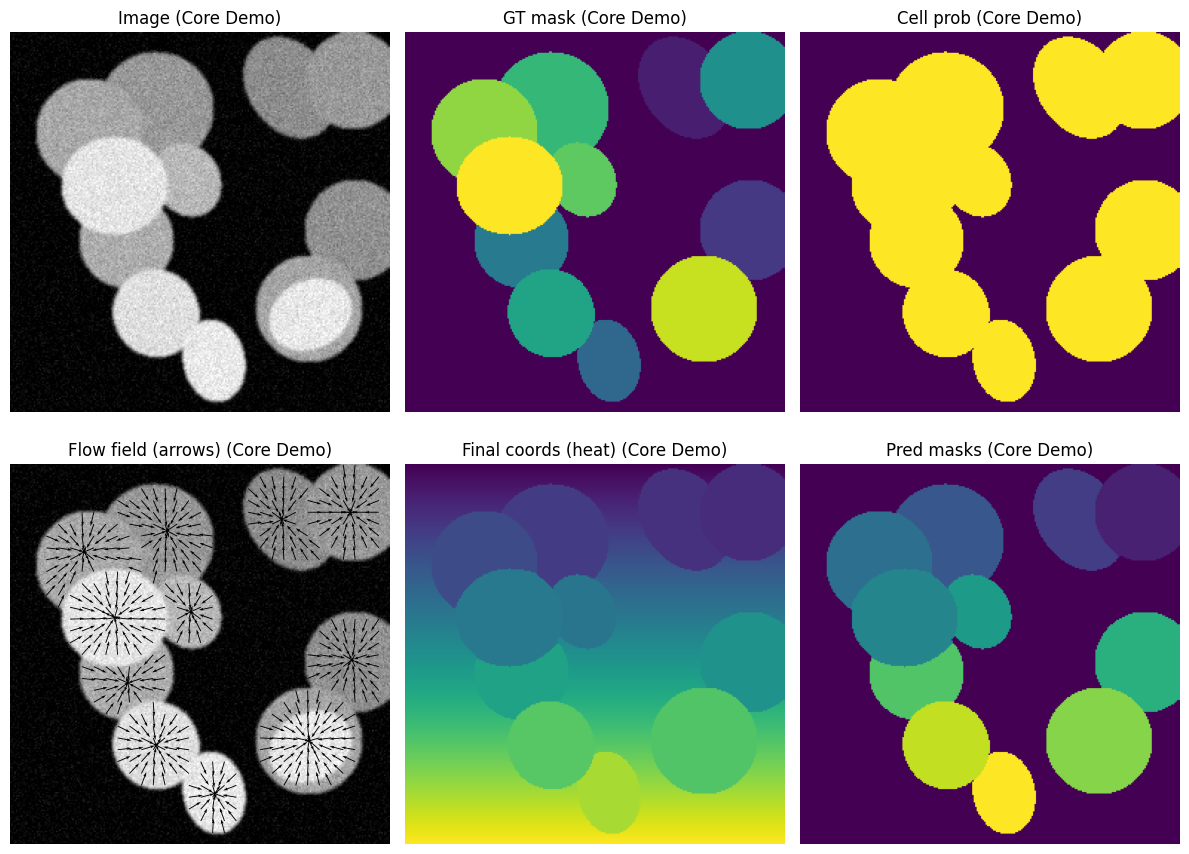

Per-gt-instance IoUs (Core Demo): [0.998 1.    1.    0.992 0.999 1.    0.999 1.    0.994 1.    0.992]
Mean IoU (over GT instances, Core Demo): 0.998
Instance-level AP-like metrics (Core Demo): {'TP': 11, 'FP': 0, 'FN': 0, 'AP_like': 1.0}


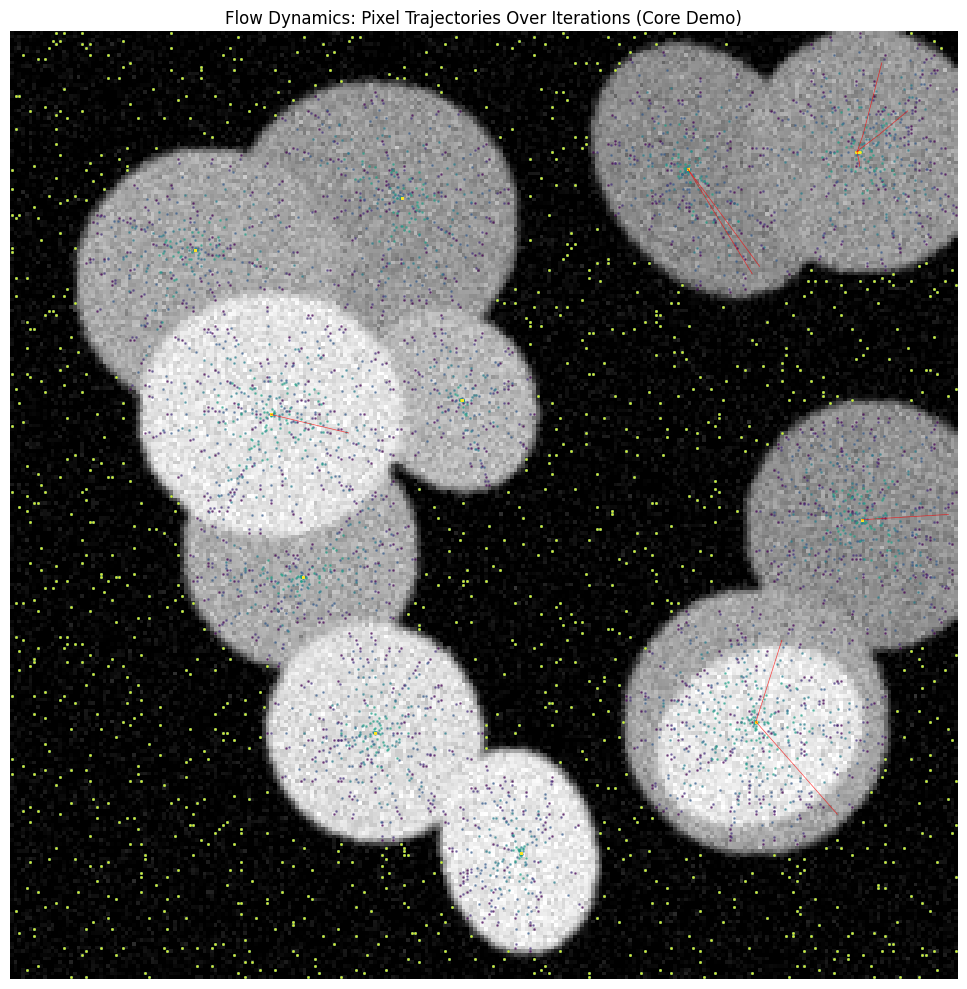

--- Core Flow-Field Segmentation Demo Complete ---


In [5]:
print("--- Starting Core Flow-Field Segmentation Demo ---")

# 1. Generate Synthetic Data
# Using parameters that might introduce some overlap and varied shapes for a good demo
demo_img, demo_gt = make_synthetic_cells(image_size=(256,256), n_cells=12, overlap_factor=0.6, shape_mix_prob=0.5, seed=42)

# 2. Compute Flows and Probability Map
demo_flow, demo_prob = labels_to_flows(demo_gt)

# 3. Follow Flows (with recording intermediate steps for dynamics visualization)
record_steps = [1, 5, 10, 20, 50, 100, 200]
demo_final_coords, demo_intermediate_coords = follow_flows(demo_flow, n_iters=200, step_size=1.0, record_steps=record_steps)

# 4. Cluster Final Positions
# Using default DBSCAN parameters (can be tuned later in the interactive section)
demo_pred_mask = cluster_final_positions(demo_final_coords, demo_prob, eps=3.0, min_samples=40)

# 5. Visualize Results
show_results(demo_img, demo_gt, demo_flow, demo_prob, demo_final_coords, demo_pred_mask, title_suffix="(Core Demo)")

# 6. Calculate and Display Metrics
demo_ious = iou_per_instance(demo_gt, demo_pred_mask)
print('Per-gt-instance IoUs (Core Demo):', np.round(demo_ious,3))
print('Mean IoU (over GT instances, Core Demo):', np.round(demo_ious.mean(),3))
demo_metrics = instance_ap(demo_gt, demo_pred_mask, iou_thresh=0.5)
print('Instance-level AP-like metrics (Core Demo):', demo_metrics)

# 7. Visualize Flow Dynamics
visualize_flow_dynamics(demo_img, demo_intermediate_coords, record_steps, title_suffix="(Core Demo)")

print("--- Core Flow-Field Segmentation Demo Complete ---")

## Interactive DBSCAN Parameter Tuning

Below is an interactive widget that allows user to adjust parameters for the DBSCAN clustering algorithm:
- `eps`: maximum distance between two samples for one to be considered as in the neighborhood of the other.
- `min_samples`: the number of samples in a neighborhood for a point to be considered as a core point

This interactive example is **deliberately designed to clearly show the sensitivity of DBSCAN parameters** (`eps` and `min_samples`), rather than demonstrating optimal flow-field algorithm performance.

**Key aspects of this setup:**

*   **Challenging Synthetic Image:** We use many overlapping cells to create a complex scene.
*   **Reduced Flow Iterations:** Pixels don't fully converge, leaving `final_coords` somewhat spread out and ambiguous.
*   **Initial `eps` Value:** The slider starts at a value (e.g., 5.0) that might initially merge cells.

**Important Note:** This setup is *not ideal for the flow-field algorithm itself*. An optimal flow-field pipeline would use more iterations for `follow_flows` to produce very tight clusters, making DBSCAN less sensitive. Here, the ambiguity *forces* DBSCAN to make critical decisions, allowing user to clearly see how `eps` and `min_samples` dramatically affect segmentation as user adjust them (e.g., cells splitting as `eps` decreases).

In [19]:
import ipywidgets as widgets
from IPython.display import display, clear_output

print("Generating a challenging synthetic image with fewer flow iterations for interactive DBSCAN tuning...")

# Generate a synthetic image with significantly more cells and higher overlap
# to explicitly demonstrate DBSCAN parameter sensitivity, likely leading to merged clusters initially.
img_less_defined, gt_less_defined = make_synthetic_cells(
    image_size=(256, 256),
    n_cells=20, # Increased number of cells to create denser regions
    overlap_factor=0.7, # Significantly increased overlap
    shape_mix_prob=0.5, # Mix shapes for more complexity
    seed=300 # New fixed seed for reproducibility
)

# Compute flows and probability map for the modified image
flow_less_defined, prob_less_defined = labels_to_flows(gt_less_defined)

# Follow flows for the modified image with FEWER ITERATIONS to create less distinct clusters
final_less_defined = follow_flows(flow_less_defined, n_iters=20, step_size=1.0) # Reduced iterations to 20

# Calculate initial metrics for the modified image with default DBSCAN params
# These values are for display and do not directly control the interactive widget's starting point
pred_less_defined_default = cluster_final_positions(final_less_defined, prob_less_defined, eps=3.0, min_samples=10)
ious_less_defined = iou_per_instance(gt_less_defined, pred_less_defined_default)
metrics_less_defined = instance_ap(gt_less_defined, pred_less_defined_default, iou_thresh=0.5)

print("Challenging synthetic image and associated flow data generated successfully.")

def interactive_dbscan_segmentation(img, gt_mask, flow, prob, final_coords):
    output = widgets.Output()

    def update(eps, min_samples):
        with output:
            clear_output(wait=True)
            pred_mask = cluster_final_positions(final_coords, prob, eps=eps, min_samples=min_samples)

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 3, 1)
            plt.title('Image')
            plt.imshow(img, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title('Predicted Masks (DBSCAN)')
            plt.imshow(pred_mask)
            plt.axis('off')

            # Calculate and display metrics
            ious = iou_per_instance(gt_mask, pred_mask)
            mean_iou = np.round(ious.mean(), 3) if len(ious) > 0 else 0.0
            metrics = instance_ap(gt_mask, pred_mask, iou_thresh=0.5)

            plt.subplot(1, 3, 3)
            plt.title('Metrics')
            plt.text(0.1, 0.8, f'Mean IoU: {mean_iou}', fontsize=12)
            plt.text(0.1, 0.7, f'AP-like: {metrics["AP_like"]}', fontsize=12)
            plt.text(0.1, 0.6, f'TP: {metrics["TP"]}', fontsize=12)
            plt.text(0.1, 0.5, f'FP: {metrics["FP"]}', fontsize=12)
            plt.text(0.1, 0.4, f'FN: {metrics["FN"]}', fontsize=12)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            print(f"--- DBSCAN Parameters: eps={eps}, min_samples={min_samples} ---")
            print('Mean IoU (over GT instances):', mean_iou)
            print('Instance-level AP-like metrics:', metrics)

    # Set initial eps to a value that likely causes some merging, making changes more apparent when reduced.
    eps_slider = widgets.FloatSlider(min=0.5, max=15.0, step=0.1, value=5.0, description='EPS') # Initial value set to 5.0
    min_samples_slider = widgets.IntSlider(min=5, max=100, step=5, value=10, description='Min Samples')

    # Link sliders to update function
    interactive_widget = widgets.interactive(update, eps=eps_slider, min_samples=min_samples_slider)
    display(interactive_widget, output)

# Now, interact with the DBSCAN parameters for this highly challenging image:
print("Interactive DBSCAN segmentation for the highly challenging image:")
interactive_dbscan_segmentation(img_less_defined, gt_less_defined, flow_less_defined, prob_less_defined, final_less_defined)


Generating a challenging synthetic image with fewer flow iterations for interactive DBSCAN tuning...
Challenging synthetic image and associated flow data generated successfully.
Interactive DBSCAN segmentation for the highly challenging image:


interactive(children=(FloatSlider(value=5.0, description='EPS', max=15.0, min=0.5), IntSlider(value=10, descri…

Output()

In [22]:
import torch
import torch.nn as nn

# Tiny flow decoder for Cellpose-like flow prediction
class TinyFlowHead(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 1)   # (flow_x, flow_y, prob)
        )
    def forward(self, x):
        return self.net(x)

# Ensure global variable exists
tiny_head = None



--- Starting SAM Integration and Visualization ---
🔽 Downloading SAM checkpoint: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
📦 Downloaded size: 357.67 MB
✅ Checkpoint downloaded correctly.
✅ SAM model loaded successfully on device: cpu
🔍 Generating SAM image embeddings...
📐 Embedding shape: torch.Size([1, 256, 64, 64])


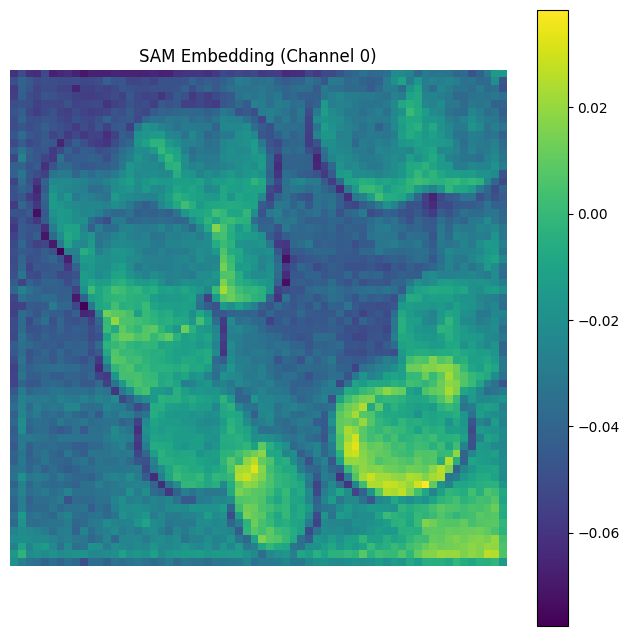

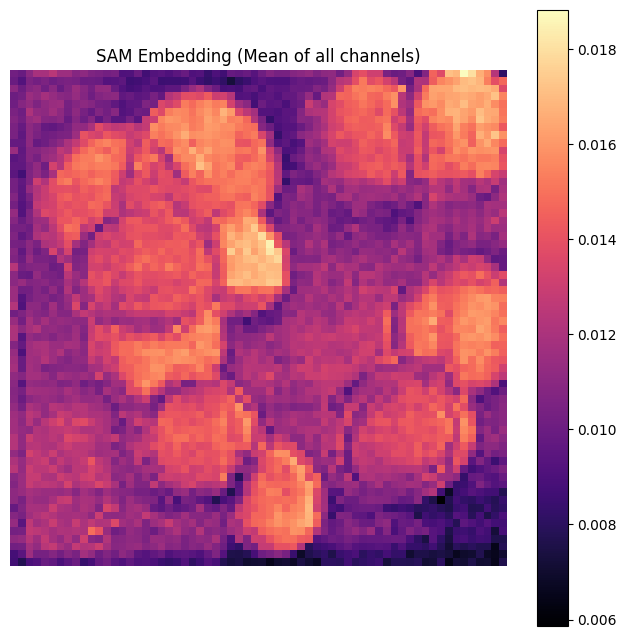

✨ SAM embedding visualization complete.
--- SAM Integration and Visualization Complete ---


In [6]:
print("\n--- Starting SAM Integration and Visualization ---")

if not HAS_SAM:
    print("❌ SAM is not available. Skipping SAM integration.")
else:
    # 1. Download SAM Checkpoint if needed
    if not os.path.exists(SAM_CHECKPOINT):
        ok = download_sam_checkpoint()
        if not ok:
            print("❌ SAM checkpoint invalid or missing. Aborting SAM part.")
            HAS_SAM = False # Mark SAM as effectively unavailable
    else:
        print("📁 SAM checkpoint already exists. Skipping download.")

    if HAS_SAM:
        # 2. Load SAM Model
        try:
            sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
            sam.to(DEVICE)
            sam.eval()
            print("✅ SAM model loaded successfully on device:", DEVICE)
        except Exception as e:
            print("❌ Error loading SAM:", e)
            HAS_SAM = False

    if HAS_SAM:
        # 3. Prepare Image for SAM
        # SAM expects RGB input, so convert the grayscale synthetic image
        img_rgb_for_sam = np.stack([demo_img, demo_img, demo_img], axis=-1)
        img_pil = Image.fromarray((img_rgb_for_sam * 255).astype(np.uint8))

        # SAM uses ImageNet-style normalization and expects 1024x1024 input
        sam_transform = Compose([
            Resize((1024, 1024)),
            ToTensor(),
            Normalize(
                mean=[0.485, 0.456, 0.406], # ImageNet mean for RGB
                std=[0.229, 0.224, 0.225]  # ImageNet std for RGB
            )
        ])
        input_tensor = sam_transform(img_pil).unsqueeze(0).to(DEVICE)

        # 4. Run SAM Encoder to Generate Image Embeddings
        print("🔍 Generating SAM image embeddings...")
        with torch.no_grad():
            image_embeddings = sam.image_encoder(input_tensor)
        print("📐 Embedding shape:", image_embeddings.shape)

        # 5. Visualize Embeddings
        plt.figure(figsize=(8,8))
        plt.imshow(image_embeddings[0, 0].cpu().numpy(), cmap="viridis")
        plt.title("SAM Embedding (Channel 0)")
        plt.axis("off")
        plt.colorbar()
        plt.show()

        plt.figure(figsize=(8,8))
        plt.imshow(image_embeddings[0].mean(dim=0).cpu().numpy(), cmap="magma")
        plt.title("SAM Embedding (Mean of all channels)")
        plt.axis("off")
        plt.colorbar()
        plt.show()

        print("✨ SAM embedding visualization complete.")

print("--- SAM Integration and Visualization Complete ---")


--- Running Full Cellpose-SAM Pipeline ---
📐 Upsampled SAM embeddings to: torch.Size([1, 256, 256, 256])
🌬️ Flow predicted: (256, 256, 2)
🧪 Probability: (256, 256)
📍 Final coords: (256, 256, 2)
🎉 Predicted mask: (256, 256)


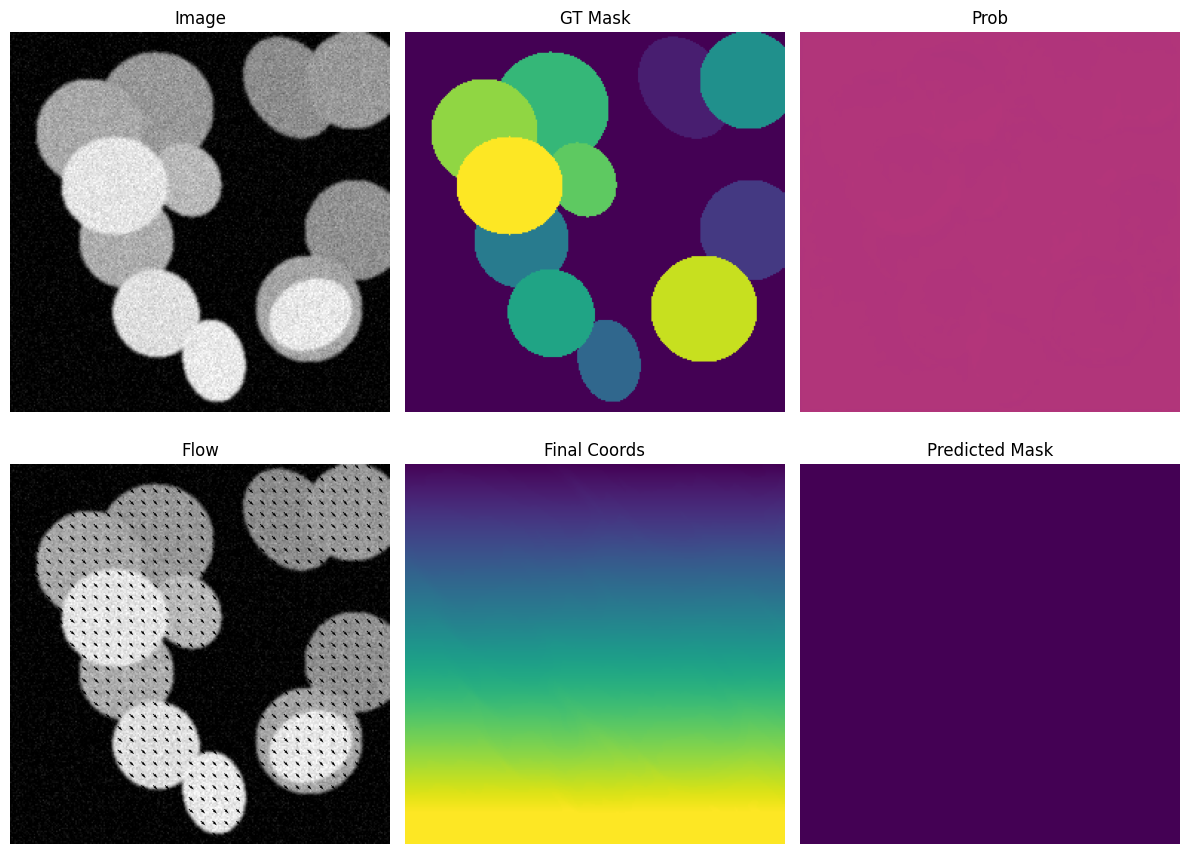

--- Cellpose-SAM Pipeline Complete ---


In [27]:
################################################################################
# SAM → FlowHead → Flow Field → Cellpose Dynamics → Final Masks
################################################################################
print("\n--- Running Full Cellpose-SAM Pipeline ---")

if not HAS_SAM:
    print("❌ SAM not available. Skipping Cellpose-SAM pipeline.")
else:
    try:
        image_embeddings
    except NameError:
        print("❌ SAM embeddings not found. Please run SAM visualization section first.")
        raise

    # Upsample SAM embeddings to 256×256
    feats = F.interpolate(
        image_embeddings,
        size=(256,256),
        mode="bilinear",
        align_corners=False
    )
    print("📐 Upsampled SAM embeddings to:", feats.shape)

    # Create TinyFlowHead if missing
    global tiny_head
    if tiny_head is None:
        in_ch = feats.shape[1]
        tiny_head = TinyFlowHead(in_ch=in_ch).to(DEVICE)
        print(f"🧩 Created TinyFlowHead (in_ch={in_ch})")

    # Run TinyFlowHead → flow_x, flow_y, prob
    with torch.no_grad():
        out = tiny_head(feats)
    flow_t, prob_t = decode_head_output(out)

    flow = flow_t[0].permute(1,2,0).cpu().numpy()
    prob = prob_t[0,0].cpu().numpy()

    print("🌬️ Flow predicted:", flow.shape)
    print("🧪 Probability:", prob.shape)

    # ★★★ Correct function name: use your notebook's follow_flows ★★★
    final = follow_flows(flow, n_iters=200, step_size=1.0)
    print("📍 Final coords:", final.shape)

    # Cluster
    pred_mask = cluster_final_positions(final, prob, eps=3.0, min_samples=40)
    print("🎉 Predicted mask:", pred_mask.shape)

    # Visualization
    plt.figure(figsize=(12,9))
    plt.subplot(2,3,1); plt.title("Image"); plt.imshow(demo_img,cmap='gray'); plt.axis('off')
    plt.subplot(2,3,2); plt.title("GT Mask"); plt.imshow(demo_gt); plt.axis('off')
    plt.subplot(2,3,3); plt.title("Prob"); plt.imshow(prob,cmap='magma',vmin=0,vmax=1); plt.axis('off')

    plt.subplot(2,3,4); plt.title("Flow")
    H,W = demo_img.shape
    step = 8
    Y,X = np.mgrid[0:H:step,0:W:step]
    U = flow[::step,::step,0]
    V = flow[::step,::step,1]
    plt.imshow(demo_img,cmap='gray')
    plt.quiver(X,Y,U,V,angles='xy')
    plt.axis('off')

    plt.subplot(2,3,5); plt.title("Final Coords")
    plt.imshow(final[:,:,0], cmap='viridis'); plt.axis('off')

    plt.subplot(2,3,6); plt.title("Predicted Mask")
    plt.imshow(pred_mask); plt.axis('off')

    plt.tight_layout()
    plt.show()

print("--- Cellpose-SAM Pipeline Complete ---")
